In [4]:
import time
import random
import os
import threading
import plotly.express as px
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
####################################################################################################################################
def increaseY():
    global Y_t,fps_
    Y_t+=fps_             #virtual queue fps:30
    threading.Timer(1, increaseY).start()

def inferenceFunction(latency):
    time.sleep(latency)
    return 1

def makeResource():
    #resource
    min_resource=900000000    # min:900Mhz
    max_resource=2000000000 # max:2Ghz
    resorce_step=10000000    # step:10Mhz
    resorce_list=[i for i in range(min_resource,max_resource+1,resorce_step)] #length: 4000
    
    #making resource_simulation
    resource_simulation=[0]*image_num
    for each_image in range(image_num):
        if(each_image<(image_num//3)):# early state -> high resource(Idle)
            resource_simulation[each_image]=resorce_list[random.sample(range(-(len(resorce_list)//10),0),k=1)[0]]
        elif((image_num//3)<=each_image<((image_num*2)//3)):# middle state -> low resource
            resource_simulation[each_image]=resorce_list[random.sample(range((len(resorce_list)//10)),k=1)[0]]
        else:# last state -> middle resource
            resource_simulation[each_image]=resorce_list[random.sample(range((len(resorce_list)//3),(len(resorce_list)//3)*2),k=1)[0]]
    file_name = './data/resource_simul_exit2.txt'
    with open(file_name, 'w+') as file:
        file.write('\n'.join(list(map(str,resource_simulation))))  # '\n' 대신 ', '를 사용하면 줄바꿈이 아닌 ', '를 기준으로 문자열 구분함

def makeDPP(exit,Y_t,p_th):
    global mAP_list
    DPP=(2*Y_t*(p_th-mAP_list[exit]))+((p_th-mAP_list[exit])**2)
    return DPP

def makeLatency(exit,current_resource):
    global computation_exit
    latency=computation_exit[exit]/current_resource
    return latency

def loadResource(file_name):
    resorce_simul=[]
    with open(file_name, "r") as file:
        for i in file:
            resorce_simul.append(int(i.strip()))
    return resorce_simul

def makeObjective():
    pass
####################################################################################################################################
#main function
def main():
    global Y_t,result_latency_mAP,result_data_status,total_exit
    file_name='./data/resource_simul_exit2.txt'
    resorce_simul=loadResource(file_name)
    #increaseY()             # virtual queue fps:30 !!!!!!!!!!!!!!!!!!START!!!!!!!!!!!!!!
    
    for image in range(image_num): #image만큼 iteration process
        current_resource=resorce_simul[image] #dynamic resource state
        #calculate objective function and get target exit number
        objective=infinity
        target_exit=total_exit-1       #initializing target_exit as final exit
        for exit in range(total_exit):
            latency=makeLatency(exit,current_resource)
            DPP=makeDPP(exit,Y_t,p_th)
            if(DPP + (V*latency)<objective):
                objective = DPP + (V*latency)
                target_exit=exit

        # inference step
        #inferenceFunction(latency) # this make latency function, so this can be commentize
        
        # after inference
        inference_result_mAP=random.randint(int(mAP_list[target_exit]+.5)-10,int(mAP_list[target_exit]+.5)+10)
        result_latency_mAP[0]+= makeLatency(target_exit,current_resource)  #latency
        result_latency_mAP[1]+= inference_result_mAP/image_num #mAP
        result_data_status.append([current_resource,target_exit,makeDPP(target_exit,Y_t,p_th),makeLatency(target_exit,current_resource)])
        Y_t=max(Y_t+p_th-inference_result_mAP,0)
        print(f'{image}번째 이미지의 exit: {target_exit}, resource값: {current_resource}, objective값: {objective}')
####################################################################################################################################
#constant variables 
infinity=int(1e9)
total_exit=2            #exit number is 2
####################################################################################################################################
#hyperparameters
V=4*(10**8)                    # Latency weight constants
p_th=75                 # random value
image_num=5000          # image number
fps_=30                 # fps:30
####################################################################################################################################
#layer class
layer_calculation={     # each layer's calculation value
    'init_layer':1,
    'layer1':7,
    'layer2':10,
    'layer3':50,
    'layer4':16,
    'RPN':4,
    'Detector':16,
    'EE':3}
computation_exit=[0]*total_exit 
computation_exit[0]=(layer_calculation['init_layer']+layer_calculation['layer1']+layer_calculation['layer2']+layer_calculation['EE']+layer_calculation['RPN']+layer_calculation['Detector'])
computation_exit[1]=(layer_calculation['init_layer']+layer_calculation['layer1']+layer_calculation['layer2']+layer_calculation['layer3']+layer_calculation['RPN']+layer_calculation['Detector'])
#computation_exit=[41, 88] we only use exit-2 and exit-3
####################################################################################################################################
#expectation accuracy
mAP_list=[63.81,70.07]  # 2-exit exist and each has expectation mAP
####################################################################################################################################
#variables initialize
target_exit=total_exit-1# initializing target exit as last exit
Y_t=0                   # initialize virtual queue
objective=0             # objective function value
####################################################################################################################################
result_latency_mAP=[0]*2# result_latency_mAP[0]: latency, result_latency_mAP[1]: mAP
result_data_status=[]   # result_data_status[0]: resource, result_data_status[1]: final-exit, result_data_status[2]: dpp, result_data_status[3]: latency
####################################################################################################################################
#run
makeResource()
if __name__ == "__main__":
    if not (os.path.exists('./data/resource_simul_exit2.txt')):
        makeResource()
    main()
    

0번째 이미지의 exit: 1, resource값: 1990000000, objective값: 41.99334221105534
1번째 이미지의 exit: 1, resource값: 1960000000, objective값: 150.7240836734696
2번째 이미지의 exit: 1, resource값: 1960000000, objective값: 288.7640836734698
3번째 이미지의 exit: 1, resource값: 1950000000, objective값: 298.7161820512825
4번째 이미지의 exit: 1, resource값: 2000000000, objective값: 308.1249000000005
5번째 이미지의 exit: 1, resource값: 1920000000, objective값: 407.4582333333339
6번째 이미지의 exit: 1, resource값: 1910000000, objective값: 358.25421937172825
7번째 이미지의 exit: 1, resource값: 1910000000, objective값: 476.5742193717284
8번째 이미지의 exit: 1, resource값: 1950000000, objective값: 624.096182051283
9번째 이미지의 exit: 1, resource값: 1900000000, objective값: 673.8712157894746
10번째 이미지의 exit: 1, resource값: 1960000000, objective값: 722.6040836734704
11번째 이미지의 exit: 1, resource값: 2000000000, objective값: 850.4249000000012
12번째 이미지의 exit: 1, resource값: 1940000000, objective값: 890.4092298969085
13번째 이미지의 exit: 1, resource값: 1960000000, objective값: 939.5240836734707
14

In [6]:
#make dataframe method 2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V')
#find V
if not (os.path.exists("data/simul_exit2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V').csv")):
    df = pd.DataFrame(columns=['p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V'])
    p_th=70
    for exit in range(4):
        for Y_t in tqdm(range(0,1000,50),desc=f"exit:{exit}th Y_t",leave=False):
            DPP=makeDPP(exit,Y_t,p_th)
            for current_resource in range(min_resource,max_resource+1,resorce_step*10):
                latency=makeLatency(exit,current_resource)
                for V in range(10**8,10**9,10**8):#1.35e-08(0~1),2.175e-08(1~2),3.925e-08(2~3)
                    target_exit=3                
                    objective = DPP + (V*latency)
                    df.loc[len(df)] = {'V' : V,'Y_t' : Y_t,'current_resource' : current_resource, 'exit' : exit, 'latency' : latency,'DPP' : DPP,'objective':objective}
    df.to_csv("data/simul_exit2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V').csv", index=False)

'#make dataframe method 2(\'p_th\',\'Y_t\',\'exit\',\'DPP\',\'current_resource\',\'latency\',\'type\',\'objective\',\'V\')\n#find V\ndf = pd.DataFrame(columns=[\'p_th\',\'Y_t\',\'exit\',\'DPP\',\'current_resource\',\'latency\',\'type\',\'objective\',\'V\'])\np_th=70\nfor exit in range(4):\n    for Y_t in tqdm(range(0,1000,50),desc=f"exit:{exit}th Y_t",leave=False):\n        DPP=makeDPP(exit,Y_t,p_th)\n        for current_resource in range(min_resource,max_resource+1,resorce_step*10):\n            latency=makeLatency(exit,current_resource)\n            for V in range(10**8,10**9,10**8):#1.35e-08(0~1),2.175e-08(1~2),3.925e-08(2~3)\n                target_exit=3                \n                objective = DPP + (V*latency)\n                df.loc[len(df)] = {\'V\' : V,\'Y_t\' : Y_t,\'current_resource\' : current_resource, \'exit\' : exit, \'latency\' : latency,\'DPP\' : DPP,\'objective\':objective}\ndf.to_csv("data/simul_exit2(\'p_th\',\'Y_t\',\'exit\',\'DPP\',\'current_resource\',\'late

In [7]:
if not (os.path.exists("data/simul_exit2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V').csv")):
    df = pd.read_csv("data/simul_exit2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V').csv")
    fig = px.line_3d(df, x="V", y="Y_t", z="objective", color='exit')
    fig.show()
'''
Y_t랑 DPP는 선형 비례관계라고 추측
Y_t랑 p_th는 ?? 평면인데?
DPP는 p_th는 선형 비례관계 추측
'''

FileNotFoundError: [Errno 2] No such file or directory: "data/simul_exit2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V').csv"

In [ ]:
if not (os.path.exists("data/simul_exit2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V').csv")):
    df = pd.read_csv("data/simul_exit2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V').csv")
    fig = px.line_3d(df, x="current_resource", y="exit", z="latency", color='type')
    fig.show()
'''
exit, latency 당근빠따로 exit이 뒤로가면 latency 커짐, 그 정도가 지수정도?
exit, current_resource ?? 좀 그지같이 나옴... 같은 exit인데 c_r이 분포가 미쳣는데?
current_resource, latency 리소스가 많으면 latency 작아짐.. 당연 직접적인것이니;;
'''

In [92]:
#computation_exit=[24, 54, 87, 157]
#expectation accuracy: mAP_list=[63,70]  # 4-exit exist and each has expectation mAP

#TODO show theoretical latency and mAP of each exit with bar histogram
#latency, mAP

file_name='./data/resource_simul_exit2.txt'
resorce_simul=loadResource(file_name)
latency_result=[[0 for _ in range(2)] for _ in range(total_exit)]

for exit in range(total_exit):
    for current_resource in resorce_simul:
        latency_result[exit][0]+=makeLatency(exit,current_resource)
        latency_result[exit][1]+=random.randint(int(mAP_list[exit]+.5)-(mAP_list[exit]//10),int(mAP_list[exit]+.5)+(mAP_list[exit]//10))
    latency_result[exit][1]/=len(resorce_simul)
latency_result.append(result_latency_mAP)
#my algorithm value

latency_result

[[0.00015458403879677212, 64.0548],
 [0.0003317901320516036, 69.978],
 [0.0003317901320516036, 69.91459999999961]]

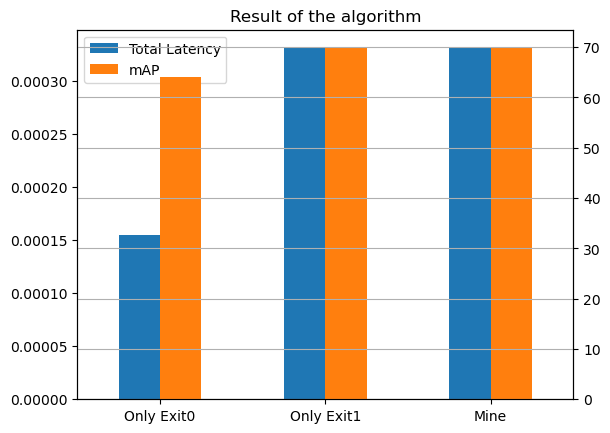

In [93]:

df_result=pd.DataFrame(latency_result,columns=['Total Latency','mAP'],index=['Only Exit0','Only Exit1','Mine'])

df_result.plot( kind= 'bar' , secondary_y= 'mAP' , rot= 0 ,title='Result of the algorithm',mark_right=False,grid=True)
plt.show()

In [94]:
#make dataframe method 2('p_th','Y_t','exit','DPP','current_resource','latency','type','objective','V')
file_name='./data/resource_simul_exit2.txt'
resorce_simul=loadResource(file_name)
df_resource=pd.DataFrame(data=resorce_simul,columns=['resource'])

In [98]:
from plotly.offline import plot
from plotly.subplots import make_subplots

df_result=pd.DataFrame(result_data_status,columns=['current_resource','target_exit','DPP','Latency'])
figures = [
            px.line(df_resource, x=df_resource.index, y="resource", title="Resource status",height=1000),
            px.line(df_result, x=df_result.index, y="target_exit",height=1000),#limit y-axis
            px.line(df_result, x=df_result.index, y="DPP",height=1000),
            px.line(df_result, x=df_result.index, y="Latency",height=1000)
    ]

fig = make_subplots(rows=len(figures), cols=1,row_heights=[1000]*len(figures), subplot_titles=df_result.columns)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)
        
fig.show()